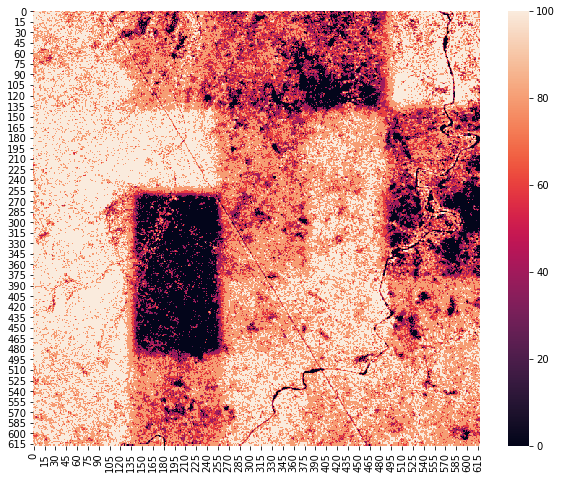

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import numpy as np
plt.figure(figsize=(10,8))

x = str(2379)
y = str(959)

data = pd.read_csv("../../src/processing_area_june_28.csv")

import matplotlib.pyplot as plt
artifact = plt.imread(f"../../project-monitoring/tof-output/{x}/{y}/{x}X{y}Y_POST.tif")
artifact = artifact.astype(np.float32)
sns.heatmap(artifact)

In [83]:
import yaml
%run ../../src/downloading/io.py
import glob

yaml_path = "../../config.yaml"
with open(yaml_path, 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY= key['key']
    AWSKEY = key['awskey']
    AWSSECRET = key['awssecret']
print(f"Successfully loaded key from {yaml_path}")
uploader = FileUploader(awskey = AWSKEY, awssecret = AWSSECRET, overwrite = True)

path_to_process = f"../../project-monitoring/tiles/{str(x)}/{str(y)}/"
s3_path_to_process = f'2020/processed/{str(x)}/{str(y)}/'

download_folder(bucket = "tof-output",
                   apikey = AWSKEY,
                   apisecret = AWSSECRET,
                   local_dir = path_to_process,
                   s3_folder = s3_path_to_process)

Successfully loaded key from ../../config.yaml
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/0/0.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/0/119.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/0/238.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/0/358.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/0/478.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/116/0.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/116/119.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/116/238.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/116/358.npy')
s3.ObjectSummary(bucket_name='tof-output', key='2020/processed/1399/1181/processed/116/478.npy

<Figure size 432x288 with 0 Axes>

In [50]:


files_to_load = glob.glob(f"../../project-monitoring/tiles/{str(x)}/{str(y)}/processed/*/*.npy")
medians = []
for file in files_to_load[5:7]:
    idx = np.load(file)
    #print(np.mean(idx))
    if np.max(idx) <= 100:
        idx = np.nanmedian(idx)
        medians.append(idx)
    
medians = np.median(medians)
print("THE MEDIAN IS", medians)

# Median adjustment

for file in files_to_load:
    idx = np.load(file)
    x_med = np.median(idx)
    print(medians - x_med, file)
    if np.max(idx) <= 100:
        if (medians - x_med) > (0.6 * medians):
            print("WOW")
            idx = np.full((140, 140), 255)
            np.save(file, idx)

THE MEDIAN IS 0.28734583
0.2525038 ../../project-monitoring/tiles/1539/1047/processed/476/478.npy
WOW
0.23077989 ../../project-monitoring/tiles/1539/1047/processed/476/119.npy
WOW
-0.56848186 ../../project-monitoring/tiles/1539/1047/processed/476/0.npy
0.24165392 ../../project-monitoring/tiles/1539/1047/processed/476/238.npy
WOW
0.25756004 ../../project-monitoring/tiles/1539/1047/processed/476/358.npy
WOW
0.26042658 ../../project-monitoring/tiles/1539/1047/processed/0/478.npy
WOW
-0.26042658 ../../project-monitoring/tiles/1539/1047/processed/0/119.npy
-0.30654597 ../../project-monitoring/tiles/1539/1047/processed/0/0.npy
0.05886896 ../../project-monitoring/tiles/1539/1047/processed/0/238.npy
0.2513367 ../../project-monitoring/tiles/1539/1047/processed/0/358.npy
WOW
0.2543487 ../../project-monitoring/tiles/1539/1047/processed/119/478.npy
WOW
0.24487545 ../../project-monitoring/tiles/1539/1047/processed/119/119.npy
WOW
-0.05126506 ../../project-monitoring/tiles/1539/1047/processed/119/0.

In [9]:
import os
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

def load_mosaic_predictions(out_folder: str) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    """
    x_tiles = [int(x) for x in os.listdir(out_folder) if '.DS' not in x]
    max_x = np.max(x_tiles) + 140
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        max_y = np.max(y_tiles) + 140
    predictions = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), np.nan, dtype = np.float32)
    mults = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), 0, dtype = np.float32)
    i = 0
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                if np.sum(prediction) < 140*140*255:
                    prediction = (prediction * 100).T.astype(np.float32)
                    predictions[x_tile: x_tile+140, y_tile:y_tile + 140, i] = prediction
                    mults[x_tile: x_tile+140, y_tile:y_tile + 140, i] = fspecial_gauss(140, 20)
                i += 1

    predictions = predictions.astype(np.float32)
    mults = mults / np.sum(mults, axis = -1)[..., np.newaxis]
    predictions[predictions > 100] = np.nan
    out = np.copy(predictions)
    out = np.sum(np.isnan(out), axis = (2))
    n_preds = predictions.shape[-1]
    predictions = np.nansum(predictions * mults, axis = -1)
    predictions[out == n_preds] = np.nan
    predictions[np.isnan(predictions)] = 255.
    predictions = predictions.astype(np.uint8)
                
    original_preds = np.copy(predictions)
    for x_i in range(0, predictions.shape[0] - 3):
        for y_i in range(0, predictions.shape[1] - 3):
            window = original_preds[x_i:x_i+3, y_i:y_i+3]
            if np.max(window) < 35:
                sum_under_35 = np.sum(np.logical_and(window > 10, window < 35))
                if np.logical_and(sum_under_35 > 6, sum_under_35 < 10):
                    window = 0.

            # This removes or mitigates some of the "noisiness" of individual trees
            # Which could have odd shapes depending on where they sit within or between
            # Sentinel pixels 
            if np.max(window) >= 25 and np.argmax(window) == 4:
                window_binary = window >= 25
                if np.sum(window_binary) < 4:
                    if np.sum(window_binary[1]) < 3 and np.sum(window_binary[:, 1]) < 3:
                        window[0, :] = 0
                        window[2, :] = 0
                        window[:, 0] = 0
                        window[:, 2] = 0
                print(np.sum(window == 80))
                if np.sum(window == 80) >= 5:
                    print("Woop")
                    window = 100.
    predictions = original_preds 

    predictions[predictions <= .25*100] = 0.        
    predictions = np.around(predictions / 20, 0) * 20
    predictions[predictions > 100] = 255.
    return predictions

In [96]:
smooth = load_mosaic_predictions(f"../../project-monitoring/tiles/{x}/{y}/processed/")
smooth = smooth.astype(np.uint8)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
2
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
2
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0


0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


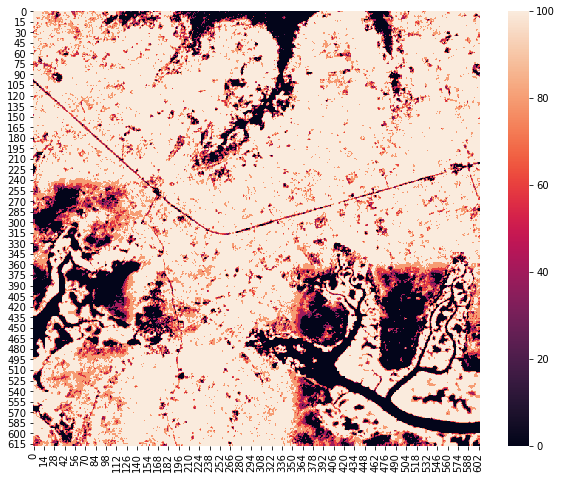

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,8))
sns.heatmap(smooth.T, vmax = 100)

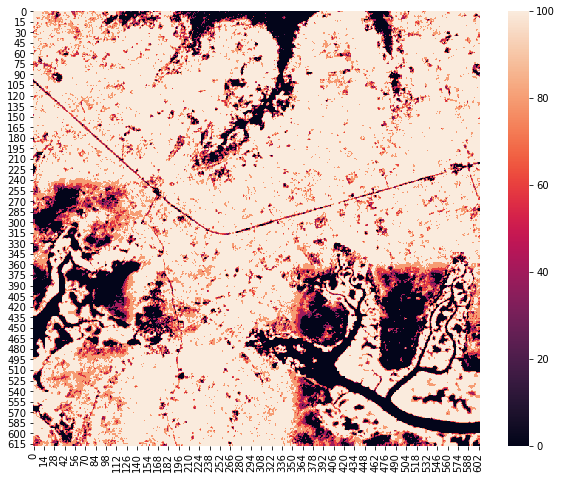

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,8))
sns.heatmap(smooth.T, vmax = 100)

In [4]:
import copy
import tensorflow as tf
from glob import glob
import rasterio
import os

def make_bbox(initial_bbx: list, expansion: int = 10) -> list:
    """Makes a (min_x, min_y, max_x, max_y) bounding box that
       is 2 * expansion 300 x 300 meter ESA LULC pixels

       Parameters:
            initial_bbx (list): [min_x, min_y, max_x, max_y]
            expansion (int): 1/2 number of 300m pixels to expand

       Returns:
            bbx (list): expanded [min_x, min_y, max_x, max_y]
    """
    multiplier = 1/360 # Sentinel-2 pixel size in decimal degrees
    bbx = copy.deepcopy(initial_bbx)
    bbx[0] -= expansion * multiplier
    bbx[1] -= expansion * multiplier
    bbx[2] += expansion * multiplier
    bbx[3] += expansion * multiplier
    return bbx

data = data[data['Y_tile'] == int(y)]
data = data[data['X_tile'] == int(x)]
data = data.reset_index(drop = True)
x = str(int(x))
y = str(int(y))
x = x[:-2] if ".0" in x else x
y = y[:-2] if ".0" in y else y

initial_bbx = [data['X'][0], data['Y'][0], data['X'][0], data['Y'][0]]
bbx = make_bbox(initial_bbx, expansion = 300/30)

file = write_tif(smooth, bbx, x, y, f"../../project-monitoring/tiles/{x}/{y}/")
key = f'2020/tiles/{x}/{y}/{str(x)}X{str(y)}Y_POST.tif'
uploader.upload(bucket = 'tof-output', key = key, file = file)

NameError: name 'write_tif' is not defined

# NEw stuff

import pandas as pd
import boto3
import os
#data = pd.read_csv("reprocess.csv")
#data.head(5)

bucket = "tof-output"
s3 = boto3.client('s3', aws_access_key_id=AWSKEY,
         aws_secret_access_key= AWSSECRET)

for index, row in data.iterrows():
    x = str(int(row['X_tile']))
    y = str(int(row['Y_tile']))
    local_path = f"../../project-monitoring/tof-output/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_POST.tif"
    s3_path = f"2020/tiles/{str(x)}/{str(y)}/{str(x)}X{str(y)}Y_POST.tif"
    
    print(f"Deleting {x}/{y}")
    try:
        #s3.delete_object(Bucket = "tof-output", Key = s3_path)
    except:
        print(f"No file at: {s3_path}")
        continue
    try:
       # os.remove(local_path)
    except:
        continue

In [31]:
import os
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

def load_mosaic_predictions(out_folder: str) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    """
    x_tiles = [int(x) for x in os.listdir(out_folder) if '.DS' not in x]
    max_x = np.max(x_tiles) + 56
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        max_y = np.max(y_tiles) + 56
    predictions = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), np.nan, dtype = np.float32)
    predictions = np.full((618, 618, 390), np.nan, dtype = np.float32)
    mults = np.full((max_x, max_y, len(x_tiles) * len(y_tiles)), 0, dtype = np.float32)
    mults = np.full((618, 618, 390), 0, dtype = np.float32)
    i = 0
    print(predictions.shape)
    for x_tile in x_tiles:
        y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                if np.sum(prediction) < 56*56*255:
                    prediction = (prediction * 100).T.astype(np.float32)
                    predictions[x_tile: x_tile+56, y_tile:y_tile + 56, i] = prediction
                    mults[x_tile: x_tile+56, y_tile:y_tile + 56, i] = fspecial_gauss(56, 16)
                i += 1

    predictions = predictions.astype(np.float32)
    mults = mults / np.sum(mults, axis = -1)[..., np.newaxis]
    predictions[predictions > 100] = np.nan
    out = np.copy(predictions)
    out = np.sum(np.isnan(out), axis = (2))
    n_preds = predictions.shape[-1]
    predictions = np.nansum(predictions * mults, axis = -1)
    predictions[out == n_preds] = np.nan
    predictions[np.isnan(predictions)] = 255.
    predictions = predictions.astype(np.uint8)
                
    original_preds = np.copy(predictions)
    for x_i in range(0, predictions.shape[0] - 3):
        for y_i in range(0, predictions.shape[1] - 3):
            window = original_preds[x_i:x_i+3, y_i:y_i+3]
            if np.max(window) < 35:
                sum_under_35 = np.sum(np.logical_and(window > 10, window < 35))
                if np.logical_and(sum_under_35 > 6, sum_under_35 < 10):
                    window = 0.

            # This removes or mitigates some of the "noisiness" of individual trees
            # Which could have odd shapes depending on where they sit within or between
            # Sentinel pixels 
            if np.max(window) >= 25 and np.argmax(window) == 4:
                window_binary = window >= 25
                if np.sum(window_binary) < 4:
                    if np.sum(window_binary[1]) < 3 and np.sum(window_binary[:, 1]) < 3:
                        window[0, :] = 0
                        window[2, :] = 0
                        window[:, 0] = 0
                        window[:, 2] = 0
                    
    predictions = original_preds 

    predictions[predictions <= .25*100] = 0.        
    predictions = np.around(predictions / 20, 0) * 20
    predictions[predictions > 100] = 255.
    return predictions

In [32]:
smooth = load_mosaic_predictions(f"../../project-monitoring/tiles/{x}/{y}/processed/")
smooth = smooth.astype(np.uint8)

(618, 618, 390)


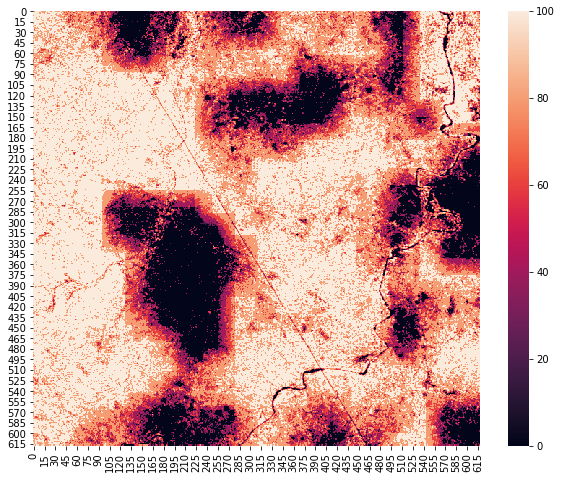

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(smooth.T, vmax = 100)

In [14]:
import copy
import tensorflow as tf
from glob import glob
import rasterio
%run ../../src/downloading/io.py


def make_bbox(initial_bbx: list, expansion: int = 10) -> list:
    """Makes a (min_x, min_y, max_x, max_y) bounding box that
       is 2 * expansion 300 x 300 meter ESA LULC pixels

       Parameters:
            initial_bbx (list): [min_x, min_y, max_x, max_y]
            expansion (int): 1/2 number of 300m pixels to expand

       Returns:
            bbx (list): expanded [min_x, min_y, max_x, max_y]
    """
    multiplier = 1/360 # Sentinel-2 pixel size in decimal degrees
    bbx = copy.deepcopy(initial_bbx)
    bbx[0] -= expansion * multiplier
    bbx[1] -= expansion * multiplier
    bbx[2] += expansion * multiplier
    bbx[3] += expansion * multiplier
    return bbx

data = data[data['Y_tile'] == int(y)]
data = data[data['X_tile'] == int(x)]
data = data.reset_index(drop = True)
x = str(int(x))
y = str(int(y))
x = x[:-2] if ".0" in x else x
y = y[:-2] if ".0" in y else y

initial_bbx = [data['X'][0], data['Y'][0], data['X'][0], data['Y'][0]]
bbx = make_bbox(initial_bbx, expansion = 300/30)

file = write_tif(smooth, bbx, x, y, f"../../project-monitoring/tiles/{x}/{y}/")

Writing ../../project-monitoring/tiles/2379/959/2379X959Y_POST.tif


In [75]:
import rasterio as rs
tof_data = rs.open("../../src/Liberia.tif")
width = tof_data.shape[1]
height = tof_data.shape[0]
tof_array = tof_data.read(1)



In [76]:
tof_data_clip = np.where(tof_array == 80, 1, 0)
print(tof_data_clip.shape)
tof_data_clip = tof_data_clip[:, :-3].reshape(46350 // 5, 5, 41750 // 5, 5)
tof_data_clip = np.sum(tof_data_clip, axis = (1, 3))
tof_data_clip[tof_data_clip >= 20] = 100.
tof_data_clip = tof_data_clip.repeat(5,axis=0).repeat(5,axis=1).astype(np.uint8)

(46350, 41753)


In [78]:
tof_data_clip = numpy.pad(tof_data_clip, [[0, 0], [0, 3]], mode='constant')

In [79]:
tof_array[tof_data_clip == 100] = tof_data_clip[tof_data_clip == 100]

In [81]:

bounds = tof_data.bounds
transform = rs.transform.from_bounds(west = bounds[0], south = bounds[1],
                                               east = bounds[2], north = bounds[3],
                                               width = tof_array.shape[1], 
                                               height = tof_array.shape[0])
new_dataset = rs.open("liberia-updated.tif", 'w', 
                      driver='GTiff',
                      height=tof_array.shape[0], 
                      width=tof_array.shape[1], 
                      count=1,
                      dtype="uint8",
                      crs='+proj=longlat +datum=WGS84 +no_defs',
                      transform=transform)

new_dataset.write(np.array(tof_array), 1)
new_dataset.close()

In [74]:
np.max(tof_data_clip)

100